# P-values for simple binned cut-and-count experiments

Here, we perform a simple cut and count experiment, drawing data from a 2D Gaussian. Binning the distributions we calculate the expectation value per pin using the pdf of the distribution (i.e. oversampling infinitely) and use Poisson statistics to obtain the significance.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm
from sklearn.ensemble import HistGradientBoostingClassifier

In [82]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

First we define some helper functions including one generating the data, one calculating p-values from significances and one (with its own helper function) calculating the significances themselves using the Asimov estimate.

In [88]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(abs(sig)))

def sig(N, b, err):
    """
    Complicated significance formula calculation where N=N_obs, b = N_exp and err=delta_sys
    """
    if err==0:
        s=N-b
        x=N*np.log(1+s/b)-s
        x[x<0]=0
        return np.sqrt(2*(x))
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)
    x = ln1 - ln2
    x[x<0]=0
    return np.sqrt(x)

def significance_formula(N_data, N_BT):
    return sig(N_data, N_BT, 0)

def significance_naive(N_data, N_BT):
    return (N_data-N_BT)/np.sqrt(N_BT)

We then perform a number of tests $N_\text{tests}$ using $N$ datapoints collected in a certain number of bins. For the sake of computation time, we use a fixed binning so that the expectation only needs to be calculated once. Then data is drawn $N_\text{tests}$ times and the significances per bin are calculated with the binning fixed above.  

In [81]:
N_tests = 100000
bins=5
N = 100000

sigs2 = np.zeros((bins*bins, N_tests))
rv = multivariate_normal([0,0], [[1,0],[0,1]])
_, edges = np.histogramdd(rv.rvs(size=100000), bins=bins)

exp2 = np.zeros((bins,bins))
for i in range(bins):
    for j in range(bins):
        exp2[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N
exp2 = exp2.flatten()

for k in tqdm.tqdm(range(N_tests)):
    data = rv.rvs(size=N)
    hist = np.histogramdd(data, bins=edges)[0].flatten()
    #print(hist)
    sigs2[:, k] = significance_formula(hist, exp2)

  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/js/9l9sh13j11n06p8lb8x3_6980000gn/T/ipykernel_18187/3976211350.py:9: RuntimeWarning: divide by zero encountered in log
  x=N*np.log(1+s/b)-s
/var/folders/js/9l9sh13j11n06p8lb8x3_6980000gn/T/ipykernel_18187/3976211350.py:9: RuntimeWarning: invalid value encountered in multiply
  x=N*np.log(1+s/b)-s
100%|██████████| 100000/100000 [09:35<00:00, 173.79it/s]


In [ ]:
N_tests = 100000
bins=5
N = 100000

sigs = np.zeros((bins*bins, N_tests))
rv = multivariate_normal([0,0], [[1,0],[0,1]])
_, edges = np.histogramdd(rv.rvs(size=100000), bins=bins)

exp = np.zeros((bins,bins))
for i in range(bins):
    for j in range(bins):
        exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N
exp = exp.flatten()

for k in tqdm.tqdm(range(N_tests)):
    data = rv.rvs(size=N)
    hist = np.histogramdd(data, bins=edges)[0].flatten()
    #print(hist)
    sigs[:, k] = significance_formula(hist, exp)

  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/js/9l9sh13j11n06p8lb8x3_6980000gn/T/ipykernel_18187/3976211350.py:9: RuntimeWarning: divide by zero encountered in log
  x=N*np.log(1+s/b)-s
/var/folders/js/9l9sh13j11n06p8lb8x3_6980000gn/T/ipykernel_18187/3976211350.py:9: RuntimeWarning: invalid value encountered in multiply
  x=N*np.log(1+s/b)-s
100%|██████████| 100000/100000 [09:52<00:00, 168.68it/s]


In [89]:
N_tests = 100000
bins=5
N = 100000

sigs3 = np.zeros((bins*bins, N_tests))
rv = multivariate_normal([0,0], [[1,0],[0,1]])
_, edges = np.histogramdd(rv.rvs(size=100000), bins=bins)

exp3 = np.zeros((bins,bins))
for i in range(bins):
    for j in range(bins):
        exp3[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N
exp3 = exp3.flatten()

for k in tqdm.tqdm(range(N_tests)):
    data = rv.rvs(size=N)
    hist = np.histogramdd(data, bins=edges)[0].flatten()
    #print(hist)
    sigs3[:, k] = significance_naive(hist, exp3)

100%|██████████| 100000/100000 [09:18<00:00, 178.90it/s]


To check whether the p-values are correctly calibrated, we then calculate the observed probability of each significance $\mathcal{S_i}$ (number of occurences of $\mathcal{S}\ge\mathcal{S_i}$) and compare with the nominal p-value. 

We first do this for a single bin to check the general calculation.

(25, 100000)


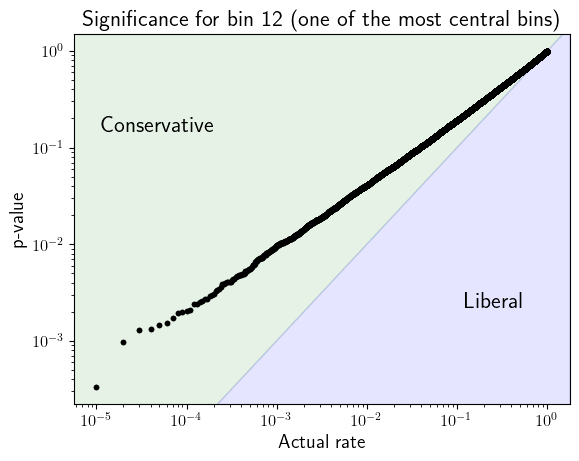

In [128]:
plt.figure()
plt.title("Significance for bin 12 (one of the most central bins)")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

print(sigs3.shape)
sig_use = np.sort(sigs[12])[::-1]
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)

plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")

(25, 100000)


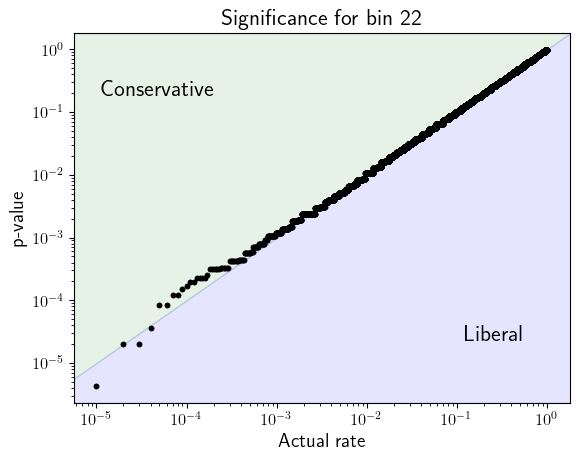

In [130]:
plt.figure()
plt.title("Significance for bin 22")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

print(sigs3.shape)
sig_use = np.sort(sigs[22])[::-1]
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)

plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")

Treating every bin as an independent test, we then do the same with the flattened array of all significances. 

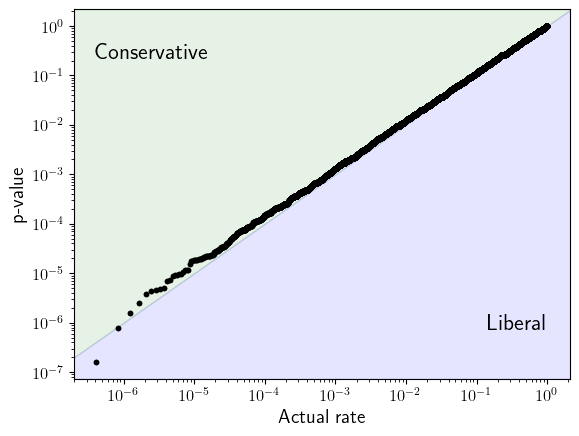

In [125]:
plt.figure()
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

sig_use = np.sort(sigs.flatten())[::-1]
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)

x = [1/len(sig_use), 1]
#plt.plot(x, x, color="black")
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")



Lastly, we take the max of all bins within one drawing from the dataset, i.e. performing multiple trials per dataset. We use the Bonferroni Correction and multiply the p-value by the total number of bins. This is a conservative correction as can be seen in the plot.

2428310
(100000,)


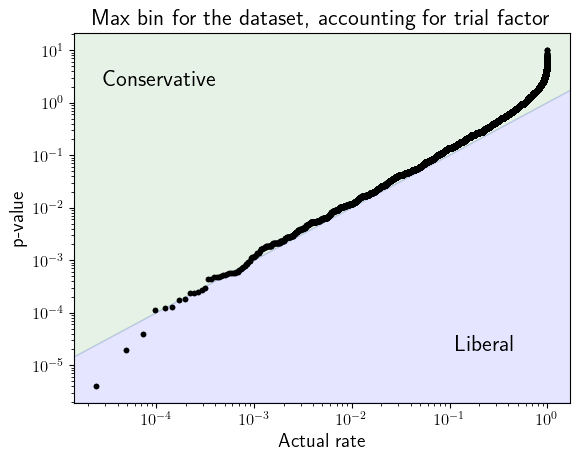

In [126]:
plt.figure()
plt.title("Max bin for the dataset, accounting for trial factor")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

print(np.sum(np.isfinite(sigs)))
sig_use = np.sort(np.max(sigs, axis=0))[::-1]
print(sig_use.shape)
trial_factor = bins*bins
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)*trial_factor

plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")